In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("/content/drive/MyDrive/ori_PointNetLK-master")

In [3]:
import argparse
import os
import sys
import logging
import time
import tqdm
import numpy as np
import torch
import torch.utils.data
import torchvision
from scipy.spatial.transform import Rotation
from sklearn.neighbors import KDTree

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), os.pardir)))
import ptlk

In [21]:
def options(argv=None):
    parser = argparse.ArgumentParser(description='PointNet-LK')

    parser.add_argument('-o', '--outfile', default='fixpnlk_5L1', type=str,
                        metavar='BASENAME', help='output filename (prefix)')     

    parser.add_argument('-i', '--dataset-path', default='', type=str,
                        metavar='PATH', help='path to the input dataset') # like '/path/to/ModelNet40'
    parser.add_argument('-c', '--categoryfile', default='', type=str,
                        metavar='PATH', help='path to the categories to be tested') # eg. './sampledata/modelnet40_half1.txt'
    parser.add_argument('-p', '--perturbations', default='', type=str,
                        metavar='PATH', help='path to the perturbation file') # see. generate_perturbations.py

    # settings for input data
    parser.add_argument('--dataset-type', default='modelnet', choices=['modelnet'],
                        metavar='DATASET', help='dataset type (default: modelnet)')
    parser.add_argument('--format', default='wv', choices=['wv', 'wt'],
                        help='perturbation format (default: wv (twist)) (wt: rotation and translation)') 

    # settings for PointNet-LK
    parser.add_argument('--max-iter', default=30, type=int,
                        metavar='N', help='max-iter on LK.')
    parser.add_argument('--transfer-from', default='', type=str,
                        metavar='PATH', help='path to classifier feature (default: null (no-use))')
    parser.add_argument('--dim-k', default=1024, type=int,
                        metavar='K', help='dim. of the feature vector (default: 1024)')
    parser.add_argument('--symfn', default='max', choices=['max', 'avg'],
                        help='symmetric function (default: max)')
    parser.add_argument('--delta', default=1.0e-2, type=float,
                        metavar='D', help='step size for approx. Jacobian (default: 1.0e-2)')

    # settings for on training
    parser.add_argument('-l', '--logfile', default='', type=str,
                        metavar='LOGNAME', help='path to logfile (default: null (no logging))')
    parser.add_argument('-j', '--workers', default=4, type=int,
                        metavar='N', help='number of data loading workers (default: 4)')
    parser.add_argument('-b', '--batch-size', default=16, type=int,
                        metavar='N', help='mini-batch size (default: 32)')
    parser.add_argument('--epochs', default=200, type=int,
                        metavar='N', help='number of total epochs to run')
    parser.add_argument('--start-epoch', default=0, type=int,
                        metavar='N', help='manual epoch number (useful on restarts)')
    parser.add_argument('--optimizer', default='Adam', choices=['Adam', 'SGD'],
                        metavar='METHOD', help='name of an optimizer (default: Adam)')
    parser.add_argument('--resume', default='', type=str,   
                        metavar='PATH', help='path to latest checkpoint (default: null (no-use))')
    parser.add_argument('--pretrained', default='', type=str,
                        metavar='PATH', help='path to pretrained model file (default: null (no-use))')
    parser.add_argument('--device', default='cuda:0', type=str,
                        metavar='DEVICE', help='use CUDA if available')
    args = parser.parse_args(argv)
    return args

In [5]:
class Action:
    def __init__(self, args):
        # PointNet
        self.transfer_from = args.transfer_from
        self.dim_k = args.dim_k
        self.sym_fn = None
        if args.symfn == 'max':
            self.sym_fn = ptlk.pointnet.symfn_max
        elif args.symfn == 'avg':
            self.sym_fn = ptlk.pointnet.symfn_avg
        # LK
        self.delta = args.delta
        self.max_iter = args.max_iter
        self.xtol = 1.0e-7
        self.p0_zero_mean = True
        self.p1_zero_mean = True

        self._loss_type = 1 # see. self.compute_loss()        

    def create_model(self):
        ptnet = self.create_pointnet_features()
        return self.create_from_pointnet_features(ptnet)

    def create_pointnet_features(self):
        ptnet = ptlk.pointnet.PointNet_features(self.dim_k, use_tnet=False, sym_fn=self.sym_fn)
        if self.transfer_from and os.path.isfile(self.transfer_from):
            ptnet.load_state_dict(torch.load(self.transfer_from, map_location='cpu'))
        return ptnet

    def create_from_pointnet_features(self, ptnet):
        return ptlk.pointlk.PointLK(ptnet, self.delta)

    def train_1(self, model, trainloader, optimizer, device):
        model.train()
        vloss = 0.0
        gloss = 0.0
        count = 0
        for i, data in enumerate(tqdm.tqdm(trainloader)):
            loss, loss_g = self.compute_loss(model, data, device)

            # forward + backward + optimize
            optimizer.zero_grad()
            loss_g.backward()
            optimizer.step()

            vloss1 = loss.item()
            vloss += vloss1
            gloss1 = loss_g.item()
            gloss += gloss1
            count += 1

        ave_vloss = float(vloss)/count
        ave_gloss = float(gloss)/count
        return ave_vloss, ave_gloss

    def eval_1(self, model, testloader, device):
        model.eval()
        vloss = 0.0
        gloss = 0.0
        count = 0
        with torch.no_grad():
            for i, data in enumerate(testloader):
                loss, loss_g = self.compute_loss(model, data, device)

                vloss1 = loss.item()
                vloss += vloss1
                gloss1 = loss_g.item()
                gloss += gloss1
                count += 1

        ave_vloss = float(vloss)/count
        ave_gloss = float(gloss)/count
        return ave_vloss, ave_gloss

    def compute_loss(self, model, data, device):
        srcpcd, tgtpcd, G = data
        est_g, r = self.do_estimate(tgtpcd, srcpcd, model, device)

        igt = ptlk.se3.inverse(G)
        loss_g = ptlk.pointlk.PointLK.comp(est_g, igt.to(est_g))

        if self._loss_type == 0:
            loss_r = ptlk.pointlk.PointLK.rsq(r)
            loss = loss_r
        elif self._loss_type == 1:
            loss_r = ptlk.pointlk.PointLK.rsq(r)
            loss = loss_r + loss_g
        elif self._loss_type == 2:
            pr = model.prev_r
            if pr is not None:
                loss_r = ptlk.pointlk.PointLK.rsq(r - pr)
            else:
                loss_r = ptlk.pointlk.PointLK.rsq(r)
            loss = loss_r + loss_g
        else:
            loss = loss_g

        return loss, loss_g
                    
    def do_estimate(self, p0, p1, model, device):
        p0 = p0.to(device) # template (1, N, 3)
        p1 = p1.to(device) # source (1, M, 3)
        r = ptlk.pointlk.PointLK.do_forward(model, p0, p1, self.max_iter, self.xtol,\
                                            self.p0_zero_mean, self.p1_zero_mean)
#        f_series = model.f_series
#        r = model(p0, p1, self.max_iter)
        est_g = model.g # (1, 4, 4)

        return est_g, r

In [6]:
def save_checkpoint(state, filename, suffix):
    torch.save(state, '{}_{}.pth'.format(filename, suffix))

In [7]:
class Logger(object):
    level_relations = {
        'debug':logging.DEBUG,
        'info':logging.INFO,
        'warning':logging.WARNING,
        'error':logging.ERROR,
        'crit':logging.CRITICAL
    }#日志级别关系映射

    def __init__(self,filename,level='info',fmt='%(levelname)s:%(name)s, %(asctime)s, %(message)s'):
        
        self.logger = logging.getLogger(filename)
        format_str = logging.Formatter(fmt)#设置日志格式
        self.logger.setLevel(self.level_relations.get(level))#设置日志级别
        
        #sh = logging.StreamHandler()#往屏幕上输出
        #sh.setFormatter(format_str) #设置屏幕上显示的格式
        
        th = logging.FileHandler(filename=filename,mode='a')
        th.setFormatter(format_str)#设置文件里写入的格式
        
        #self.logger.addHandler(sh) #把对象加到logger里
        self.logger.addHandler(th)

## ModelNet数据集

In [8]:
import h5py
import glob

In [9]:
def load_data(partition):
    BASE_DIR = r'/content/drive/MyDrive'
    all_data = []
    all_label = []
    for h5_name in glob.glob(os.path.join(BASE_DIR, 'modelnet40_ply_hdf5_2048', 'ply_data_%s*.h5' % partition)):
        f = h5py.File(h5_name)
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        f.close()
        all_data.append(data)
        all_label.append(label)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)
    return all_data, all_label

In [10]:
def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.05):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1 * clip, clip)
    return pointcloud

def uniform_2_sphere(num: int = None):
    if num is not None:
        phi = np.random.uniform(0.0, 2 * np.pi, num)
        cos_theta = np.random.uniform(-1.0, 1.0, num)
    else:
        phi = np.random.uniform(0.0, 2 * np.pi)
        cos_theta = np.random.uniform(-1.0, 1.0)

    theta = np.arccos(cos_theta)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    return np.stack((x, y, z), axis=-1)

def crop(points, p_keep):
    rand_xyz = uniform_2_sphere()
    centroid = np.mean(points[:, :3], axis=0)
    points_centered = points[:, :3] - centroid

    dist_from_plane = np.dot(points_centered, rand_xyz)
    if p_keep == 0.5:
        mask = dist_from_plane > 0
    else:
        mask = dist_from_plane > np.percentile(dist_from_plane, (1.0 - p_keep) * 100)

    return points[mask, :]

In [11]:
class ModelNet40(torch.utils.data.Dataset):
    def __init__(self, partition='train', crop_type=True, gaussian_noise=False, unseen=False, halfc=True, factor=4):
        self.data, self.label = load_data(partition)
        self.partition = partition
        self.gaussian_noise = gaussian_noise
        self.unseen = unseen
        self.label = self.label.squeeze()
        self.factor = factor
        self.crop_type = crop_type
        if halfc:
            self.data = self.data[self.label<20]
            self.label = self.label[self.label<20]
        if self.unseen:
            ######## simulate testing on first 20 categories while training on last 20 categories
            if self.partition == 'test':
                self.data = self.data[self.label>=20]
                self.label = self.label[self.label>=20]
            elif self.partition == 'train':
                self.data = self.data[self.label<20]
                self.label = self.label[self.label<20]

    def __getitem__(self, item):
        pointcloud = self.data[item][:1024]
        if self.partition != 'train':
            np.random.seed(item)
        if self.gaussian_noise:
            pointcloud = jitter_pointcloud(pointcloud)
        anglex = np.random.uniform() * np.pi / self.factor
        angley = np.random.uniform() * np.pi / self.factor
        anglez = np.random.uniform() * np.pi / self.factor

        cosx = np.cos(anglex)
        cosy = np.cos(angley)
        cosz = np.cos(anglez)
        sinx = np.sin(anglex)
        siny = np.sin(angley)
        sinz = np.sin(anglez)
        Rx = np.array([[1, 0, 0],
                 [0, cosx, -sinx],
                 [0, sinx, cosx]])
        Ry = np.array([[cosy, 0, siny],
                 [0, 1, 0],
                 [-siny, 0, cosy]])
        Rz = np.array([[cosz, -sinz, 0],
                 [sinz, cosz, 0],
                 [0, 0, 1]])
        R = Rx.dot(Ry).dot(Rz)
        translation = np.array([np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5),
                                   np.random.uniform(-0.5, 0.5)])

        scr = pointcloud

        rotation = Rotation.from_euler('zyx', [anglez, angley, anglex])
        tgt = rotation.apply(scr) + translation

        if self.crop_type:
            scr = crop(scr, 0.8)
            tgt = crop(tgt, 0.8)

        G = np.concatenate((R.reshape(3, -1), translation.reshape(3, -1)), axis = 1)
        G = np.concatenate((G, [[0.,0.,0.,1.]]), axis = 0)

        return scr.astype('float32'), tgt.astype('float32'), G.astype('float32')

    def __len__(self):
        return self.data.shape[0]

## train

In [22]:
args = options([])
args

Namespace(batch_size=16, categoryfile='', dataset_path='', dataset_type='modelnet', delta=0.01, device='cuda:0', dim_k=1024, epochs=200, format='wv', logfile='', max_iter=30, optimizer='Adam', outfile='fixpnlk_5L1', perturbations='', pretrained='', resume='', start_epoch=0, symfn='max', transfer_from='', workers=4)

In [23]:
act = Action(args)
model = act.create_model()
if args.pretrained:
    assert os.path.isfile(args.pretrained)
    model.load_state_dict(torch.load(args.pretrained, map_location='cpu'))
model.to(args.device)

PointLK(
  (ptnet): PointNet_features(
    (h1): Sequential(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (h2): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
  )
)

In [24]:
LOGGER = Logger('./experiments/pnlk_5L.log',level='debug')
LOGGER.logger.debug('Training (PID=%d), %s', os.getpid(), args)

In [25]:
traindata = ModelNet40(partition='train', crop_type=True)
testdata = ModelNet40(partition='test', crop_type=True)
train_loader = torch.utils.data.DataLoader(
        traindata,
        batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
test_loader = torch.utils.data.DataLoader(
        testdata,
        batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
# optimizer
learnable_params = filter(lambda p: p.requires_grad, model.parameters())
if args.optimizer == 'Adam':
    optimizer = torch.optim.Adam(learnable_params, lr=1e-4)
else:
    optimizer = torch.optim.SGD(learnable_params, lr=0.1)

In [27]:
checkpoint = None
if args.resume:
    assert os.path.isfile(args.resume)
    checkpoint = torch.load(args.resume)
    args.start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])

if checkpoint is not None:
    min_loss = checkpoint['min_loss']
    optimizer.load_state_dict(checkpoint['optimizer'])

In [28]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [ ]:
# training
min_loss = float('inf')
val_losses = []
G_losses = []

LOGGER.logger.debug('train, begin')
for epoch in range(args.start_epoch, args.epochs):
    #scheduler.step()

    running_loss, running_gloss = act.train_1(model, train_loader, optimizer, args.device)
    val_loss, val_gloss = act.eval_1(model, test_loader, args.device)
    
    message1 = 'Epoch: {}/{}. loss: TrainSet: {:.6f}  ValidationSet: {:.6f}\n'.format(epoch+1, \
                                                args.epochs, running_loss, val_loss)
    message2 = 'gloss: TrainSet: {:.6f}  ValidationSet: {:.6f}'.format(running_gloss, val_gloss)    
    print(message1, message2)
   
    val_losses.append(val_loss)
    G_losses.append(val_gloss)

    is_best = val_gloss < min_loss
    min_loss = min(val_gloss, min_loss)

    LOGGER.logger.info('epoch, %04d, %f, %f, %f, %f', epoch + 1, running_loss, val_loss, running_gloss, val_gloss)
    snap = {'epoch': epoch + 1,
            'model': model.state_dict(),
            'min_loss': min_loss,
            'optimizer' : optimizer.state_dict(),}
    if is_best:
        save_checkpoint(snap, args.outfile, 'snap_best')
        save_checkpoint(model.state_dict(), args.outfile, 'model_best')

    save_checkpoint(snap, args.outfile, 'snap_last')
    save_checkpoint(model.state_dict(), args.outfile, 'model_last')

LOGGER.logger.debug('train, end')

  0%|          | 0/320 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 320/320 [03:23<00:00,  1.57it/s]


Epoch: 1/200. loss: TrainSet: 48839.984438  ValidationSet: 5934.530498
 gloss: TrainSet: 1.189953  ValidationSet: 1.157637


100%|██████████| 320/320 [03:23<00:00,  1.58it/s]


Epoch: 2/200. loss: TrainSet: 6807.392365  ValidationSet: 8395.393259
 gloss: TrainSet: 1.067434  ValidationSet: 1.205291


100%|██████████| 320/320 [03:23<00:00,  1.58it/s]


Epoch: 3/200. loss: TrainSet: 9771.183564  ValidationSet: 5106.950880
 gloss: TrainSet: 1.010147  ValidationSet: 1.118307


100%|██████████| 320/320 [03:23<00:00,  1.57it/s]


Epoch: 4/200. loss: TrainSet: 7111.933141  ValidationSet: 5359.187336
 gloss: TrainSet: 1.024026  ValidationSet: 1.072201


100%|██████████| 320/320 [03:23<00:00,  1.57it/s]


Epoch: 5/200. loss: TrainSet: 7164.049409  ValidationSet: 7005.685585
 gloss: TrainSet: 1.023571  ValidationSet: 1.131544


100%|██████████| 320/320 [03:24<00:00,  1.56it/s]


Epoch: 6/200. loss: TrainSet: 6315.534892  ValidationSet: 5532.291000
 gloss: TrainSet: 1.002027  ValidationSet: 1.110021


100%|██████████| 320/320 [03:26<00:00,  1.55it/s]


Epoch: 7/200. loss: TrainSet: 8217.213514  ValidationSet: 7089.349879
 gloss: TrainSet: 1.075796  ValidationSet: 1.180968


100%|██████████| 320/320 [03:23<00:00,  1.57it/s]


Epoch: 8/200. loss: TrainSet: 5685.084595  ValidationSet: 4983.037575
 gloss: TrainSet: 1.003141  ValidationSet: 1.017778


100%|██████████| 320/320 [03:23<00:00,  1.57it/s]


Epoch: 9/200. loss: TrainSet: 7224.213857  ValidationSet: 5633.265201
 gloss: TrainSet: 1.031970  ValidationSet: 1.048334


100%|██████████| 320/320 [03:23<00:00,  1.57it/s]


Epoch: 10/200. loss: TrainSet: 8078.210512  ValidationSet: 4982.465570
 gloss: TrainSet: 0.996632  ValidationSet: 1.018624


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 11/200. loss: TrainSet: 7159.895317  ValidationSet: 5664.097855
 gloss: TrainSet: 1.020599  ValidationSet: 1.063886


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 12/200. loss: TrainSet: 7140.647997  ValidationSet: 5256.769342
 gloss: TrainSet: 1.005905  ValidationSet: 1.039771


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 13/200. loss: TrainSet: 11278.043558  ValidationSet: 7962.566811
 gloss: TrainSet: 1.074200  ValidationSet: 1.071033


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 14/200. loss: TrainSet: 9031.990263  ValidationSet: 9561.167619
 gloss: TrainSet: 1.037145  ValidationSet: 1.063975


100%|██████████| 320/320 [03:23<00:00,  1.58it/s]


Epoch: 15/200. loss: TrainSet: 6698.226806  ValidationSet: 7753.755647
 gloss: TrainSet: 1.010861  ValidationSet: 1.013984


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 16/200. loss: TrainSet: 7223.217920  ValidationSet: 4578.333621
 gloss: TrainSet: 0.971144  ValidationSet: 0.936027


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 17/200. loss: TrainSet: 9197.120529  ValidationSet: 5268.259923
 gloss: TrainSet: 0.997366  ValidationSet: 1.013423


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 18/200. loss: TrainSet: 5328.606413  ValidationSet: 6542.677365
 gloss: TrainSet: 0.952773  ValidationSet: 1.186128


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 19/200. loss: TrainSet: 6759.969423  ValidationSet: 7021.501160
 gloss: TrainSet: 0.956513  ValidationSet: 1.000862


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 20/200. loss: TrainSet: 5883.045666  ValidationSet: 4804.694447
 gloss: TrainSet: 0.950969  ValidationSet: 0.953406


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 21/200. loss: TrainSet: 8584.851248  ValidationSet: 5111.293958
 gloss: TrainSet: 0.927680  ValidationSet: 0.980180


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 22/200. loss: TrainSet: 8123.805447  ValidationSet: 6109.057122
 gloss: TrainSet: 0.881839  ValidationSet: 0.966925


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 23/200. loss: TrainSet: 6583.365267  ValidationSet: 4897.342410
 gloss: TrainSet: 0.864921  ValidationSet: 0.935238


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 24/200. loss: TrainSet: 5185.226144  ValidationSet: 4785.626516
 gloss: TrainSet: 0.888689  ValidationSet: 0.925656


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 25/200. loss: TrainSet: 13786.510547  ValidationSet: 5490.705576
 gloss: TrainSet: 0.928121  ValidationSet: 0.951767


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 26/200. loss: TrainSet: 5200.921128  ValidationSet: 5547.987430
 gloss: TrainSet: 0.810299  ValidationSet: 0.871501


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 27/200. loss: TrainSet: 5709.241622  ValidationSet: 4593.572442
 gloss: TrainSet: 0.858281  ValidationSet: 0.911733


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 28/200. loss: TrainSet: 5503.395604  ValidationSet: 4665.855112
 gloss: TrainSet: 0.886579  ValidationSet: 0.932118


100%|██████████| 320/320 [03:21<00:00,  1.58it/s]


Epoch: 29/200. loss: TrainSet: 6544.196554  ValidationSet: 4593.520779
 gloss: TrainSet: 0.935152  ValidationSet: 0.869227


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 30/200. loss: TrainSet: 6965.663686  ValidationSet: 4365.510203
 gloss: TrainSet: 0.865071  ValidationSet: 0.857670


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 31/200. loss: TrainSet: 7504.562104  ValidationSet: 4442.535283
 gloss: TrainSet: 0.875911  ValidationSet: 0.879747


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 32/200. loss: TrainSet: 8184.554927  ValidationSet: 4363.919861
 gloss: TrainSet: 0.860374  ValidationSet: 0.845764


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 33/200. loss: TrainSet: 5485.508579  ValidationSet: 4472.216392
 gloss: TrainSet: 0.801749  ValidationSet: 0.820110


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 34/200. loss: TrainSet: 5035.037431  ValidationSet: 4293.911343
 gloss: TrainSet: 0.802854  ValidationSet: 0.802279


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 35/200. loss: TrainSet: 4905.735971  ValidationSet: 4190.167077
 gloss: TrainSet: 0.820470  ValidationSet: 0.852834


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 36/200. loss: TrainSet: 6546.943891  ValidationSet: 4204.080797
 gloss: TrainSet: 0.783194  ValidationSet: 0.810842


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 37/200. loss: TrainSet: 4670.476276  ValidationSet: 4128.572739
 gloss: TrainSet: 0.739677  ValidationSet: 0.801030


100%|██████████| 320/320 [03:21<00:00,  1.58it/s]


Epoch: 38/200. loss: TrainSet: 5373.241883  ValidationSet: 4163.551695
 gloss: TrainSet: 0.724889  ValidationSet: 0.810387


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 39/200. loss: TrainSet: 4812.114457  ValidationSet: 4152.783107
 gloss: TrainSet: 0.691963  ValidationSet: 0.722486


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 40/200. loss: TrainSet: 4918.325238  ValidationSet: 4331.743069
 gloss: TrainSet: 0.656539  ValidationSet: 0.750211


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 41/200. loss: TrainSet: 4620.827946  ValidationSet: 4129.824900
 gloss: TrainSet: 0.709545  ValidationSet: 0.759943


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 42/200. loss: TrainSet: 4380.548113  ValidationSet: 3821.156250
 gloss: TrainSet: 0.636080  ValidationSet: 0.673427


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 43/200. loss: TrainSet: 4345.332031  ValidationSet: 4115.443883
 gloss: TrainSet: 0.602516  ValidationSet: 0.631441


100%|██████████| 320/320 [03:21<00:00,  1.58it/s]


Epoch: 44/200. loss: TrainSet: 4365.353928  ValidationSet: 4105.559389
 gloss: TrainSet: 0.616140  ValidationSet: 0.648555


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 45/200. loss: TrainSet: 4546.220124  ValidationSet: 3923.108292
 gloss: TrainSet: 0.576821  ValidationSet: 0.635534


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 46/200. loss: TrainSet: 4346.722148  ValidationSet: 4015.315027
 gloss: TrainSet: 0.589263  ValidationSet: 0.581336


100%|██████████| 320/320 [03:22<00:00,  1.58it/s]


Epoch: 47/200. loss: TrainSet: 4279.636976  ValidationSet: 4011.922099
 gloss: TrainSet: 0.547974  ValidationSet: 0.578210


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 48/200. loss: TrainSet: 4249.940905  ValidationSet: 3862.246227
 gloss: TrainSet: 0.566684  ValidationSet: 0.566953


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 49/200. loss: TrainSet: 4101.697888  ValidationSet: 3724.152269
 gloss: TrainSet: 0.544809  ValidationSet: 0.554006


100%|██████████| 320/320 [03:21<00:00,  1.59it/s]


Epoch: 50/200. loss: TrainSet: 3965.609583  ValidationSet: 3709.812535
 gloss: TrainSet: 0.527147  ValidationSet: 0.558226


 59%|█████▉    | 189/320 [01:59<01:22,  1.59it/s]

In [ ]:
for name, param in model.named_parameters():
    print(name, param)

## t-SNE

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
#tsne_2D = TSNE(n_components=2, init='pca', random_state=42)
tsne_2D = TSNE(n_components=2, random_state=150)

In [ ]:
pt0 = np.concatenate((feas[0].numpy(), f_series[0].numpy().reshape(1, -1)), axis = 0)
pt0_2d = tsne_2D.fit_transform(pt0)

In [ ]:
ps0 = np.concatenate((feas[1].numpy(), f_series[1].numpy().reshape(1, -1)), axis = 0)
ps0_2d = tsne_2D.fit_transform(ps0)

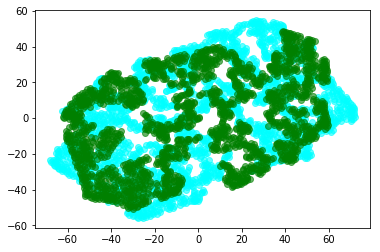

In [ ]:
plt.figure
plt.scatter(pt0_2d[:2048, 0], pt0_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps0_2d[:2048, 0], ps0_2d[:2048, 1], c='green', alpha=0.6)

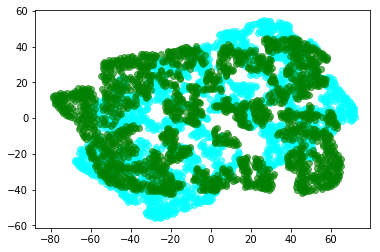

In [ ]:
ps1 = np.concatenate((feas[2].numpy(), f_series[2].numpy().reshape(1, -1)), axis = 0)
ps1_2d = tsne_2D.fit_transform(ps1)
plt.figure
plt.scatter(pt0_2d[:2048, 0], pt0_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps1_2d[:2048, 0], ps1_2d[:2048, 1], c='green', alpha=0.6)

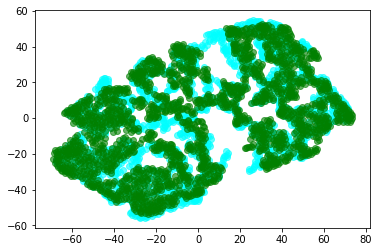

In [ ]:
ps2 = np.concatenate((feas[3].numpy(), f_series[3].numpy().reshape(1, -1)), axis = 0)
ps2_2d = tsne_2D.fit_transform(ps2)
plt.figure
plt.scatter(pt0_2d[:2048, 0], pt0_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps2_2d[:2048, 0], ps2_2d[:2048, 1], c='green', alpha=0.6)

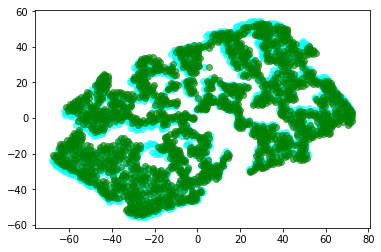

In [ ]:
ps3 = np.concatenate((feas[4].numpy(), f_series[4].numpy().reshape(1, -1)), axis = 0)
ps3_2d = tsne_2D.fit_transform(ps3)
plt.figure
plt.scatter(pt0_2d[:2048, 0], pt0_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps3_2d[:2048, 0], ps3_2d[:2048, 1], c='green', alpha=0.6)

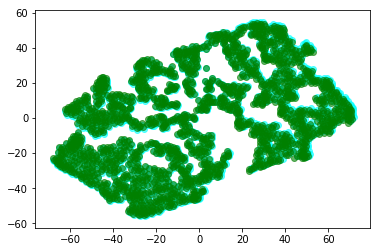

In [ ]:
ps4 = np.concatenate((feas[5].numpy(), f_series[5].numpy().reshape(1, -1)), axis = 0)
ps4_2d = tsne_2D.fit_transform(ps4)
plt.figure
plt.scatter(pt0_2d[:2048, 0], pt0_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps4_2d[:2048, 0], ps4_2d[:2048, 1], c='green', alpha=0.6)

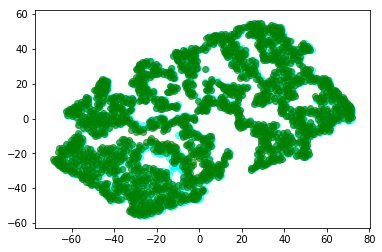

In [ ]:
ps5 = np.concatenate((feas[6].numpy(), f_series[6].numpy().reshape(1, -1)), axis = 0)
ps5_2d = tsne_2D.fit_transform(ps5)
plt.figure
plt.scatter(pt0_2d[:2048, 0], pt0_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps5_2d[:2048, 0], ps5_2d[:2048, 1], c='green', alpha=0.6)

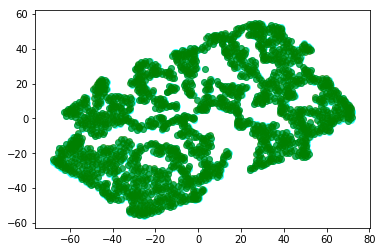

In [ ]:
ps6 = np.concatenate((feas[7].numpy(), f_series[7].numpy().reshape(1, -1)), axis = 0)
ps6_2d = tsne_2D.fit_transform(ps6)
plt.figure
plt.scatter(pt0_2d[:2048, 0], pt0_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps6_2d[:2048, 0], ps6_2d[:2048, 1], c='green', alpha=0.6)

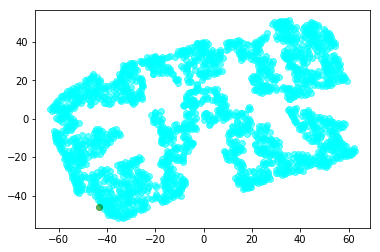

In [ ]:
ps1 = np.concatenate((feas[1].numpy(), f_series[2].numpy().reshape(1, -1)), axis = 0)
ps1_2d = tsne_2D.fit_transform(ps1)
plt.figure
plt.scatter(ps1_2d[:2048, 0], ps1_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps1_2d[2048, 0], ps1_2d[2048, 1], c='green', alpha=0.6)

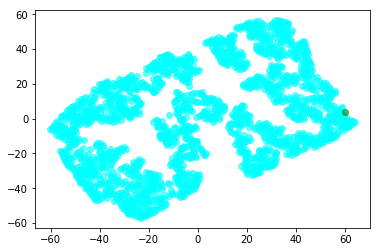

In [ ]:
psfl = np.concatenate((feas[2].numpy(), f_series[3].numpy().reshape(1, -1)), axis = 0)
psfl_2d = tsne_2D.fit_transform(psfl)
plt.figure
plt.scatter(psfl_2d[:2048, 0], psfl_2d[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(psfl_2d[2048, 0], psfl_2d[2048, 1], c='green', alpha=0.6)

In [ ]:
f_series[19], f_series[0]

(tensor([2.1081, 2.3381, 3.5178,  ..., 2.0062, 2.9503, 2.4453]),
 tensor([2.1081, 2.3381, 3.5178,  ..., 2.0062, 2.9503, 2.4453]))

## Bunny

In [ ]:
sol = np.array([2.20761e-05, -3.34606e-05, -7.20881e-05, 0.000335889, -0.708202, 0.000602459, 0.706009])     #90
r = Rotation.from_quat(sol[3:])
rot = r.as_matrix()
trans = sol[:3]
G = np.concatenate((rot.T, trans.reshape(3, -1)), axis = 1)
G = np.concatenate((G, [[0.,0.,0.,1.]]), axis = 0)

In [ ]:
bun_pt = o3d.io.read_point_cloud(r'C:\Users\fcky\Desktop\3D\bunny\bunny\data\bun000.ply')
bun_pt.paint_uniform_color([0.5, 0.5, 0.5])
bun_pt_tree = o3d.geometry.KDTreeFlann(bun_pt)
bun_ps = o3d.io.read_point_cloud(r'C:\Users\fcky\Desktop\3D\bunny\bunny\data\bun090.ply')
bun_ps.paint_uniform_color([0.5, 0.5, 0.5])

PointCloud with 30379 points.

In [ ]:
tgt = np.asarray(bun_pt.points)
scr = np.asarray(bun_ps.points)
pt = torch.tensor(tgt).unsqueeze(0).contiguous().to(torch.float32)
ps = torch.tensor(scr).unsqueeze(0).contiguous().to(torch.float32)

In [ ]:
bun_ps.transform(G)
count = 0
idxs_pt = []
idxs_ps = []
for i in range(len(bun_ps.points)):
    #[k, idx, dist] = bun00_tree.search_knn_vector_3d(bun45.points[int(ind1[i])], 3)
    [k, idx, dist] = bun_pt_tree.search_radius_vector_3d(bun_ps.points[i], 0.0005)
    if k!= 0:
        count += 1
        idxs_pt.append(idx[0])
        idxs_ps.append(i)

In [ ]:
len(idxs_pt), len(idxs_ps)

(10645, 10645)

In [ ]:
np.asarray(bun_pt.colors)[idxs_pt[0:], :] = [255/255, 127/255, 39/255]
np.asarray(bun_ps.colors)[idxs_ps[0:], :] = [160/255, 255/255, 249/255]
o3d.visualization.draw_geometries([bun_pt, bun_ps])

In [ ]:
tgtidx = torch.tensor(np.random.randint(0,tgt.shape[0],1024), dtype = torch.long)
scridx = torch.tensor(np.random.randint(0,scr.shape[0],1024), dtype = torch.long)

In [ ]:
sampt = pt[:,tgtidx,:]
samps = ps[:,scridx,:]
with torch.no_grad():
    bu_est_g, bu_r, bu_f_series, bu_feas = act.do_estimate(sampt, samps, model, args.device)

In [ ]:
bu_est_g

tensor([[[ 0.1933, -0.0919,  0.9768,  0.0015],
         [ 0.1091,  0.9914,  0.0717,  0.0039],
         [-0.9750,  0.0927,  0.2017,  0.0055],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]])

In [ ]:
g_hat = bu_est_g.cpu().contiguous().view(-1, 4, 4)
est_trans_pc0 = ptlk.se3.transform(g_hat.to(ps), ps.transpose(1,2).contiguous()).transpose(1,2).contiguous()
est_pc00 = est_trans_pc0[0].detach().numpy()
est_pc00.shape

(30379, 3)

In [ ]:
est_ptpcd = o3d.geometry.PointCloud()
est_ptpcd.points = o3d.utility.Vector3dVector(est_pc00.reshape(-1, 3))
est_ptpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
est_ptpcd.orient_normals_to_align_with_direction()
#est_ptpcd.paint_uniform_color([0.5, 0.5, 0.5])
#np.asarray(est_ptpcd.colors)[scridx[0:], :] = [160/255, 255/255, 249/255]
est_ptpcd.paint_uniform_color([160/255, 255/255, 249/255])

PointCloud with 30379 points.

In [ ]:
bun_pt.paint_uniform_color([255/255, 127/255, 39/255])
o3d.visualization.draw_geometries([bun_pt, est_ptpcd])

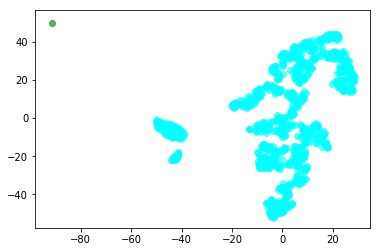

In [ ]:
bupt = np.concatenate((bu_fea_0, bu_f_series[0].numpy().reshape(1, -1)), axis = 0)
bupt_2d = tsne_2D.fit_transform(bupt)
plt.figure
plt.scatter(bupt_2d[:1024, 0], bupt_2d[:1024, 1], c='cyan', alpha=0.6)
plt.scatter(bupt_2d[1024, 0], bupt_2d[1024, 1], c='green', alpha=0.6)

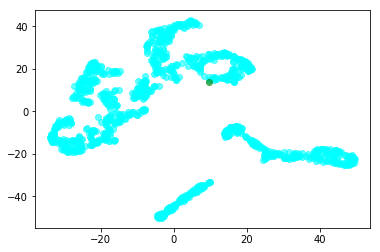

In [ ]:
#bups0 = np.concatenate((bu_feas[0].numpy(), bu_f_series[1].numpy().reshape(1, -1)), axis = 0)
bups0_2d = tsne_2D.fit_transform(bups0_pca)
plt.figure
plt.scatter(bups0_2d[:1024, 0], bups0_2d[:1024, 1], c='cyan', alpha=0.6)
plt.scatter(bups0_2d[1024, 0], bups0_2d[1024, 1], c='green', alpha=0.6)

In [ ]:
bups0 = np.concatenate((bu_feas[0].numpy(), bu_f_series[1].numpy().reshape(1, -1)), axis = 0)
bups0_pca = PCA(n_components=3).fit_transform(bups0)
bups0_pca.shape

(1025, 3)

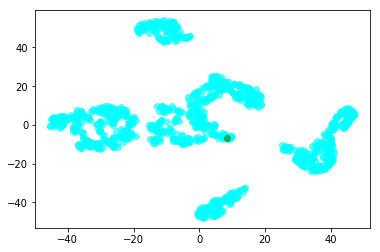

In [ ]:
bupsfl = np.concatenate((bu_feas[-1].numpy(), bu_f_series[-1].numpy().reshape(1, -1)), axis = 0)
bupsfl_2d = tsne_2D.fit_transform(bupsfl)
plt.figure
plt.scatter(bupsfl_2d[:1024, 0], bupsfl_2d[:1024, 1], c='cyan', alpha=0.6)
plt.scatter(bupsfl_2d[1024, 0], bupsfl_2d[1024, 1], c='green', alpha=0.6)

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pt0_pca = PCA(n_components=2).fit_transform(feas[0].numpy())
ps0_pca = PCA(n_components=2).fit_transform(feas[1].numpy())
pt0_pca.shape

(2048, 2)

In [ ]:
tree = KDTree(feas[0].numpy())
dist, idx = tree.query(feas[1].numpy(), k=3)

In [ ]:
dist, idx

(array([[26.90641114, 27.29365068, 27.87539377],
        [30.07638113, 30.45071125, 30.73726313],
        [15.58898835, 16.19169495, 16.22092704],
        ...,
        [ 9.26427449, 10.14555983, 10.78645232],
        [24.49296444, 24.86685095, 25.0390927 ],
        [ 3.18694553,  3.63416335,  5.65549449]]), array([[2027,  698,   72],
        [  94,  802, 1380],
        [1405, 1547,  341],
        ...,
        [ 400, 1820, 1747],
        [ 195,  760, 1130],
        [1911,  501,   10]], dtype=int64))

In [ ]:
a = np.where(dist[:,0] < np.mean(dist[:,0]))
b = idx[np.where(dist[:,0] < np.mean(dist[:,0])),0]
a, b

((array([   3,    4,    5, ..., 2042, 2045, 2047], dtype=int64),),
 array([[1153, 1810,   13, ...,  926,  452, 2005]], dtype=int64))

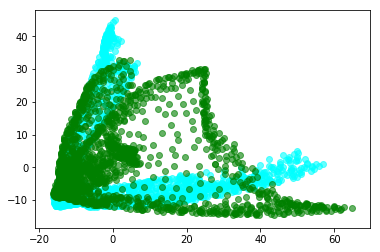

In [ ]:
plt.figure
plt.scatter(pt0_pca[:2048, 0], pt0_pca[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps0_pca[:2048, 0], ps0_pca[:2048, 1], c='green', alpha=0.6)

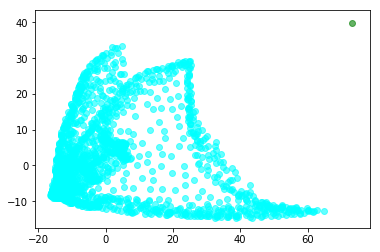

In [ ]:
ps1 = np.concatenate((feas[0].numpy(), f_series[1].numpy().reshape(1, -1)), axis = 0)
ps0_pca = PCA(n_components=2).fit_transform(ps1)
plt.figure
plt.scatter(ps0_pca[:2048, 0], ps0_pca[:2048, 1], c='cyan', alpha=0.6)
plt.scatter(ps0_pca[2048, 0], ps0_pca[2048, 1], c='green', alpha=0.6)